In [1]:
lang = ['german', 'de'] # select your file's language
''' [['arabic', 'ar'], ['azerbaijani', 'az'], ['basque', 'eu'], ['bengali', 'bn'], ['catalan', 'ca'], ['chinese', 'zh'], 
['danish', 'da'], ['dutch', 'nl'], ['english', 'en'], ['finnish', 'fi'], ['french', 'fr'], ['german', 'de'], ['greek', 'el'], 
['hebrew', 'he'], ['hinglish', 'hi'], ['hungarian', 'hu'], ['indonesian', 'id'], ['italian', 'it'], ['kazakh', 'kk'], 
['nepali', 'ne'], ['norwegian', 'no'], ['portuguese', 'pt'], ['romanian', 'ro'], ['russian', 'ru'], ['slovene', 'sl'], 
['spanish', 'es'], ['swedish', 'sv'], ['tajik', 'tg'], ['turkish', 'tr']
'''
tags = [lang, 'sentence::mining', 'Tatort', 'sentence::recognition'] # input the desired tags for ANKI
fields = [lang, 'defs', tags]

In [2]:
# extract the tar zip
import tarfile

tar_path = r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0.tar.gz"
extract_path = r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0"

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)


In [3]:
import spacy

# load from the correct folder
nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\de_core_news_sm-3.0.0\de_core_news_sm-3.0.0\de_core_news_sm\de_core_news_sm-3.0.0")

# German sentence test
doc = nlp("Das Auto ist schnell.")

# iterate through tokens
for token in doc:
    print(token.text, token.pos_, token.dep_)


C:\Users\paro\Coding Projects\Cato-AI_vs1.2\cuda\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'de_core_news_sm' (3.0.0) was trained with spaCy v3.0.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Das DET nk
Auto NOUN sb
ist AUX ROOT
schnell ADV pd
. PUNCT punct


In [4]:
''' 
SRT2CSV
vsulli
26 April 2025
read in a .srt file 
convert to a df to perform nlp
export to a .csv file for upload to ANKI
'''

import csv
import json
import nltk
import numpy as np
import pandas as pd
import pysrt
import re
import seaborn as sns
import spacy
import string

from nltk.corpus import stopwords
lang_sw = stopwords.words(lang[0])
from textblob import TextBlob

from langdetect import detect, LangDetectException

from tqdm.notebook import tqdm

# module that allows you to get meanings, translations, synonyms, and antonyms for supported langs
'''[bengali' (bn),'chinese (zh)', english' (en), 'french' (fr), 'german' (de), 
'italian' (it),'portuguese' (pt), 'romanian' (ro), 'russian'(ru), 'spanish'(es), 
'turkish' (tr)]'''
from PyMultiDictionary import MultiDictionary, DICT_EDUCALINGO
dictionary = MultiDictionary()

# allows for displaying multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
import tkinter as tk
from tkinter import filedialog

# keeps full GUI from appearing
root = tk.Tk()
root.withdraw()

# shows dialog box to ask for filename
filename = filedialog.askopenfilename()

''

In [11]:
# specify the encoding if UnicodeDecodeError
# you can open the file in NotePad and check SaveAs for default encoding
# ANSI, UTF-8
subs = pysrt.open(filename, encoding='utf-8')

In [12]:
def remove_formatting(subfile):
    # read through every sub line
    # using regex, delete section of line between <>
    # combine to string
    # update index
    for i in range(len(subfile)):
        # replace all characters between < and > with ""
        # using regex
        # strip white space from beginning
        subfile[i].text = subfile[i].text.lstrip()
        subfile[i].text = re.sub(r'<c.vtt_\w+>\s*"*', "", subfile[i].text)
        subfile[i].text = re.sub("</c>", "", subfile[i].text)
        # replace "-" with ""
        subfile[i].text = re.sub("-", "", subfile[i].text)

    return subfile

In [13]:
subs = remove_formatting(subs)

In [14]:
# create a dataframe with desired column name
def create_dataframe(subfile, col_name):
    # create dataframe
    df = pd.DataFrame(columns=[col_name])
    for i in range(len(subfile)):
        df.loc[i] = subfile[i].text
    return df

In [15]:
df = create_dataframe(subs, 'Subtitle')
df


,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...
...,...
752,<font color=#ffffff>Haben Sie Verwandte in der...
753,<font color=#ffffff>Herr Landsberger?</font>\n...
754,<font color=#ffffff>Herr Trimmel'?</font>
755,<font color=#ffffff>Wohl ein Jugendbildnis von...


In [16]:
# TODO - fix to combine across rows
# combine rows until period or end character reached
# used for gaining more context for sentiment analysis and classification
# append these rows to list and then create new df - more efficient than appending to df
# end characters at index -1 must be ) . ? ! 

def combine_rows(df, col):
    new_df_list = []
    current_row = ""
    for row in df[col]:
        if row[-1] == ")" or row[-1] == "." or row[-1] == "?" or row[-1] == "!":
            current_row += row
            new_df_list.append(current_row)
            current_row = ""
        else:
            current_row += row

    # create new df from the list of combined rows
    new_df = pd.DataFrame(new_df_list)
    new_df.rename(columns={0:col}, inplace=True)
    return new_df
    

new_df = combine_rows(df, 'Subtitle')

In [17]:
# create new dataframe removing the subtitle font tags
# go row by row - only include what's between > and < symbols

def remove_font_tags(df, col):
    new_df_list = []
    current_row = ""
    for i in range(len(df[col])):
        # slice between two characters > and < 
        match = re.findall(r'>(.*?)<', df[col][i])
        if match:
            new_df_list.append(match[0])
        else:
            new_df_list.append(df[col][i])

    return new_df_list

In [18]:
new_df_list = remove_font_tags(df,'Subtitle')

# create new df without font tags
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df


,Subtitle
0,.
1,(Motor wird angelassen)
2,Herr Landsberger?
3,"Motorhaube und Kofferraum öffnen,"
4,Machen Sie den Koffer auf!
...,...
752,Haben Sie Verwandte in der DDR?
753,Herr Landsberger?
754,Herr Trimmel'?
755,Wohl ein Jugendbildnis von Ihnen.


In [37]:
# basic exploratory data analysis
def explore_data(dataframe, column):
    print(dataframe.head())
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.describe(include='all'))
    
explore_data(new_df, 'Subtitle')

                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation                            Word Tokens  \
0                                                                        []   
1             Motor wird angelassen               [Motor, wird, angelassen]   
2                  Herr Landsberger                     [Herr, Landsberger]   
3  Motorhaube und Kofferraum öffnen   [Motorhaube, und, Kofferraum, öffnen]   
4         Machen Sie den Koffer auf         [Machen, Sie, den, Koffer, auf]   

                      Sentence Tokens                     No Stop Words  


In [38]:
# convert to lowercase
def make_lowercase(df, source_col, target_col):
    df[target_col] = df[source_col].str.lower()
    return df

In [39]:
# remove punctuation
def remove_punctuation(df, source_col, target_col):
    # ^ is a negation inside brackets (anything except)
    # starts with any word, digits, or underscore, white space character, apostrophe, + means any character in the string
    df[target_col] = df[source_col].str.replace(r"[^\w\s']+", ' ', regex = True)
    return df

In [40]:
# remove newline \n character
def remove_newline(df, source_col, target_col):
    df[target_col] = df[source_col].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [41]:
# remove newline from df
clean_df = remove_newline(new_df, 'Subtitle', 'Subtitle')
print(clean_df.head())

clean_df[102:103]

                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation                            Word Tokens  \
0                                                                        []   
1             Motor wird angelassen               [Motor, wird, angelassen]   
2                  Herr Landsberger                     [Herr, Landsberger]   
3  Motorhaube und Kofferraum öffnen   [Motorhaube, und, Kofferraum, öffnen]   
4         Machen Sie den Koffer auf         [Machen, Sie, den, Koffer, auf]   

                      Sentence Tokens                     No Stop Words  


,Subtitle,Lowercase,No Punctuation,Word Tokens,Sentence Tokens,No Stop Words
102,Jetzt reicht's.,jetzt reicht's.,Jetzt reicht's,"[Jetzt, reicht, 's]",[Jetzt reicht's],[reicht]


In [42]:
# make lowercase
clean_df = make_lowercase(clean_df, 'Subtitle', 'Lowercase')
print(clean_df.head())


                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation                            Word Tokens  \
0                                                                        []   
1             Motor wird angelassen               [Motor, wird, angelassen]   
2                  Herr Landsberger                     [Herr, Landsberger]   
3  Motorhaube und Kofferraum öffnen   [Motorhaube, und, Kofferraum, öffnen]   
4         Machen Sie den Koffer auf         [Machen, Sie, den, Koffer, auf]   

                      Sentence Tokens                     No Stop Words  


In [43]:
# remove punctuation
clean_df = remove_punctuation(clean_df, 'Subtitle', 'No Punctuation')
print(clean_df.head())
clean_df[102:103]

                            Subtitle                          Lowercase  \
0                                  .                                  .   
1            (Motor wird angelassen)            (motor wird angelassen)   
2                  Herr Landsberger?                  herr landsberger?   
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,   
4         Machen Sie den Koffer auf!         machen sie den koffer auf!   

                      No Punctuation                            Word Tokens  \
0                                                                        []   
1             Motor wird angelassen               [Motor, wird, angelassen]   
2                  Herr Landsberger                     [Herr, Landsberger]   
3  Motorhaube und Kofferraum öffnen   [Motorhaube, und, Kofferraum, öffnen]   
4         Machen Sie den Koffer auf         [Machen, Sie, den, Koffer, auf]   

                      Sentence Tokens                     No Stop Words  


,Subtitle,Lowercase,No Punctuation,Word Tokens,Sentence Tokens,No Stop Words
102,Jetzt reicht's.,jetzt reicht's.,Jetzt reicht's,"[Jetzt, reicht, 's]",[Jetzt reicht's],[reicht]


In [44]:
# word tokenizer
# basic tokenizer splits on apostrophe
# tweet tokenizer does not

def tokenize_words(df, source_col):
    df['Word Tokens'] = df[source_col].apply(nltk.word_tokenize)
    return df

In [45]:
clean_df = tokenize_words(clean_df, 'No Punctuation')
clean_df['Word Tokens']

0                                          []
1                   [Motor, wird, angelassen]
2                         [Herr, Landsberger]
3       [Motorhaube, und, Kofferraum, öffnen]
4             [Machen, Sie, den, Koffer, auf]
                        ...                  
752     [Haben, Sie, Verwandte, in, der, DDR]
753                       [Herr, Landsberger]
754                        [Herr, Trimmel, ']
755    [Wohl, ein, Jugendbildnis, von, Ihnen]
756                                        []
Name: Word Tokens, Length: 757, dtype: object

In [46]:
def tokenize_sentences(df, source_col):
    df['Sentence Tokens'] = df[source_col].apply(nltk.sent_tokenize)
    return df

In [47]:
clean_df['Sentence Tokens'] = clean_df['No Punctuation'].apply(nltk.sent_tokenize)
clean_df['Sentence Tokens']

0                                      []
1                [ Motor wird angelassen]
2                      [Herr Landsberger]
3      [Motorhaube und Kofferraum öffnen]
4             [Machen Sie den Koffer auf]
                      ...                
752      [Haben Sie Verwandte in der DDR]
753                    [Herr Landsberger]
754                       [Herr Trimmel']
755    [Wohl ein Jugendbildnis von Ihnen]
756                                    []
Name: Sentence Tokens, Length: 757, dtype: object

In [48]:
# remove stopwords

# open existing file of removed words
def load_removed_words(lang):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    #JSONDecodeError - if file is empty       
    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()
    
    removed_words.update(lang_sw)

    # save new set
    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    # return set of removed words
    return removed_words

In [49]:
# extend the stop words with list of custom words
# uppr_flag - all uppercase version of word removed
# lwr_flag - all lowercase version of word removed
# title_flag - title case of word removed
def extend_removed_words(lang, custom_stop_words, uppr_flag=False, lwr_flag=False, title_flag=False):
    # save to JSON file
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))
    except FileNotFoundError:
        removed_words = set()
    
    if uppr_flag:
        removed_words.update(list(map(str.upper, custom_stop_words)))
    
    if lwr_flag:
        removed_words.update(list(map(str.lower, custom_stop_words)))
        
    if title_flag:
        removed_words.update(list(map(str.title, custom_stop_words)))
    
    # remove only original list provided
    removed_words.update(custom_stop_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [50]:
# remove from removed words file

def add_back_words(lang, desired_words, uppr_flag=False, lwr_flag=False, title_flag=False):
    try:
        with open(lang[1]+"_removed_words.json", "r") as f:
            removed_words = set(json.load(f))

    except (FileNotFoundError, json.JSONDecodeError):
        removed_words = set()
        
    if uppr_flag:
         removed_words.difference_update(list(map(str.upper, desired_words)))
    
    if lwr_flag:
         removed_words.difference_update(list(map(str.lower, desired_words)))
        
    if title_flag:
        removed_words.difference_update(list(map(str.title, desired_words)))

    # add back words (remove from set)
    removed_words.difference_update(desired_words)

    with open(lang[1]+"_removed_words.json", "w") as f:
        json.dump(list(removed_words), f)
        
    return removed_words

In [70]:
removed_words = load_removed_words(lang)

# names of characters, places, capitalizations of pronouns, etc.
custom_stop_words = ["hallo", "paul"]

removed_words = extend_removed_words(lang, custom_stop_words, title_flag=True)

desired_words = []
removed_words = add_back_words(lang, desired_words, title_flag=True)

In [71]:
# create new column without all removed words
clean_df['No Stop Words'] = clean_df['Word Tokens'].apply(lambda x: [item for item in x if item not in removed_words])
clean_df[100:120]

,Subtitle,Lowercase,No Punctuation,Word Tokens,Sentence Tokens,No Stop Words
100,In Leipzig gekauft.,in leipzig gekauft.,In Leipzig gekauft,"[In, Leipzig, gekauft]",[In Leipzig gekauft],[gekauft]
101,Musst du immer kurze Röcke tragen?,musst du immer kurze röcke tragen?,Musst du immer kurze Röcke tragen,"[Musst, du, immer, kurze, Röcke, tragen]",[Musst du immer kurze Röcke tragen],"[kurze, Röcke, tragen]"
102,Jetzt reicht's.,jetzt reicht's.,Jetzt reicht's,"[Jetzt, reicht, 's]",[Jetzt reicht's],[reicht]
103,Hast du vor mir noch nie,hast du vor mir noch nie,Hast du vor mir noch nie,"[Hast, du, vor, mir, noch, nie]",[Hast du vor mir noch nie],[]
104,Für wen mache ich das alles?,für wen mache ich das alles?,Für wen mache ich das alles,"[Für, wen, mache, ich, das, alles]",[Für wen mache ich das alles],[]
105,Für Erich,für erich,Für Erich,"[Für, Erich]",[Für Erich],[]
106,"Für uns beide, dachte ich.","für uns beide, dachte ich.",Für uns beide dachte ich,"[Für, uns, beide, dachte, ich]",[Für uns beide dachte ich],[dachte]
107,Da kannst du alleine,da kannst du alleine,Da kannst du alleine,"[Da, kannst, du, alleine]",[Da kannst du alleine],[alleine]
108,Ich lass mir wegen dem,ich lass mir wegen dem,Ich lass mir wegen dem,"[Ich, lass, mir, wegen, dem]",[Ich lass mir wegen dem],"[lass, wegen]"
109,(Tür knallt),(tür knallt),Tür knallt,"[Tür, knallt]",[ Tür knallt],[knallt]


In [72]:
clean_df[100:101]['Subtitle']
clean_df[0:20]['No Stop Words']

100    In Leipzig gekauft.
Name: Subtitle, dtype: object

0                                      []
1                     [Motor, angelassen]
2                                      []
3        [Motorhaube, Kofferraum, öffnen]
4                                [Koffer]
5                              [Sitzbank]
6                               [schläft]
7                              [außerdem]
8                         [Handschuhfach]
9                                      []
10                               [hörbar]
11                                [Hörst]
12    [Ärmliche, Nee, förmliche, Anfrage]
13              [Strafverfolgungsbehörde]
14                            [Rastplatz]
15                          [fand, toten]
16                         [Verletzungen]
17                                 [lies]
18                    [trug, DDRKleidung]
19                                     []
Name: No Stop Words, dtype: object

In [73]:
# create a frequency diagram without stop words

# list of all words
words = []
for index, row in clean_df.iterrows():
    for word in row['No Stop Words']:
        words.append(word)
words[0:20]

['Motor',
 'angelassen',
 'Motorhaube',
 'Kofferraum',
 'öffnen',
 'Koffer',
 'Sitzbank',
 'schläft',
 'außerdem',
 'Handschuhfach',
 'hörbar',
 'Hörst',
 'Ärmliche',
 'Nee',
 'förmliche',
 'Anfrage',
 'Strafverfolgungsbehörde',
 'Rastplatz',
 'fand',
 'toten']

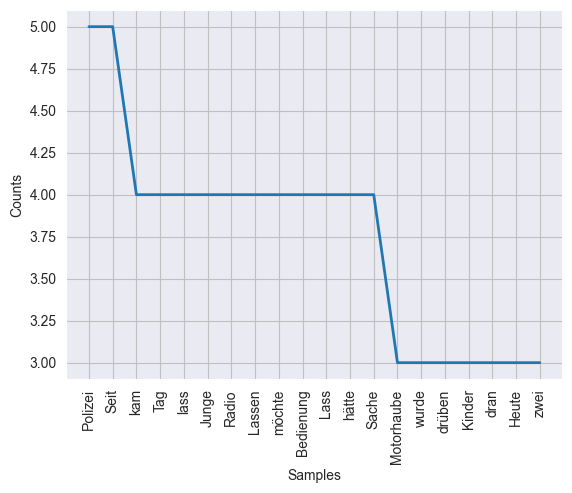

<Axes: xlabel='Samples', ylabel='Counts'>

In [74]:
# plot the word frequency
sns.set_style('darkgrid')
freq_words = nltk.FreqDist(words)
freq_words.plot(20)

In [75]:
# find the rows that contain a specific word

word = "Billsing" # a last name that can now be filtered out
pattern = rf'\b{re.escape(word)}\b'

# rows where the subtitle column contains the word
row_matches = clean_df[clean_df['Subtitle'].str.contains(pattern, case=False, regex=True, na=False)]

# return just the Subtitle column
sub_col_match = row_matches[['Subtitle']]

print(sub_col_match)

                                 Subtitle
53                  Billsing, mit zwei L.
149             Kennen Sie Eva Billsing'?
153                   Christian Billsing.
306                      ??Frl. Billsing,
387             Sie kennen Eva Billsing'?
394  weil Sie Eva Billsing privat kennen.
516          Sie waren bei Eva Billsing'?
592           Mit Eva Billsing natürlich.


In [116]:
# PyMultiDictionary to get definition

# retrieves part of speech, explanations
print(dictionary.meaning('de', 'bellen', dictionary=DICT_EDUCALINGO))


(['Verb'], 'repeated short, powerful sounds of themselves give barking sounds speak in hoarse, loud tone, call o. Ä. cause a hard, barking noise. repeatedly making short, strong sounds. Example The dog barked loudly. wiederholt kurze, kräftige Laute von sich geben bellende Laute von sich geben in heiserem, lautem ton sprechen, rufen o.\u2000Ä. ein hartes, bellendes Geräusch hervorbringen, verursachen. wiederholt kurze, kräftige Laute von sich gebenBeispielder Hund bellte laut.', '')


In [77]:
# extract only desired language from definition
def extract_desired_lang(word, lang):
    # Get the dictionary result
    res = dictionary.meaning(lang, word, dictionary=DICT_EDUCALINGO)
    
    if not res or not res[1]:
        return None
    
    pos_tags, text, _ = res
    
    # split into sentences
    sentences = text.split('. ')
    
    # desired language sentences
    my_sentences = []
    
    for sent in sentences:
        sent = sent.strip() 
        if not sent:
            continue
        
        try:
            detected_lang = detect(sent)
            
            # check if desired lang
            if detected_lang == lang:
                my_sentences.append(sent)
        except LangDetectException:
            # skip if not desired lang
            continue
    
    # combine sentences and return
    return ' '.join(my_sentences)

In [78]:
# updated for es and de
def get_article_for_noun(lang, noun):
    match lang[1]:
        case "de":
            nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\de_core_news_sm-3.0.0\de_core_news_sm-3.0.0\de_core_news_sm\de_core_news_sm-3.0.0")
        case "es":
            nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0\es_core_news_sm-3.8.0\es_core_news_sm\es_core_news_sm-3.8.0")
        case _:
            return ""
    # process the noun using spaCy
    doc = nlp(noun)
    
    # Check if it's a noun and has a valid gender tag
    # only works if appropriately capitalized
    for token in doc:
        if token.pos_ == "NOUN":
            # Based on the gender, return the correct article
            if token.morph.get("Gender") == ["Masc"]:
                return "der" if lang[1] == "de" else "el"
            elif token.morph.get("Gender") == ["Fem"]:
                return "die" if lang[1] == "de" else "la"
            elif token.morph.get("Gender") == ["Neut"]:
                return "das"
            else:
                return ""
    return ""

In [119]:
# get base form of word (for conjugated verbs & plurals)
def get_base_word(lang, word):
    match lang[1]:
        case "de":
            nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\de_core_news_sm-3.0.0\de_core_news_sm-3.0.0\de_core_news_sm\de_core_news_sm-3.0.0")
        case "es":
            nlp = spacy.load(r"C:\Users\paro\Documents\GitHub\SRT2CSV\es_core_news_sm-3.8.0\es_core_news_sm-3.8.0\es_core_news_sm\es_core_news_sm-3.8.0")
        case _:
            return ""
        
    doc = nlp(word)
    return doc[0].lemma_ # ex) "bellt -> bellen"
        
        


In [79]:
# export sentences to a .csv file

# construct a dictionary entry for all words in desired column
# word [pos]: definition
# space
# word2 [pos]: definition

# word from no stop words col ; definition ; tags
def construct_csv(df, source_col, fields, csv_name="subtitles.csv"):
    csv_rows = []
    seen_words = set()
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Exporting subtitles to CSV..."):
        sentence = row[source_col]
        words = row['No Stop Words']
        
        for w in words:
            if w in seen_words:
                break
            seen_words.add(w)
            article = get_article_for_noun(lang, w)
            meaning = dictionary.meaning(fields[0][1], w, dictionary=DICT_EDUCALINGO)
            if meaning and meaning[0]:
                pos = meaning[0][0]
            else:
                pos = "?"
            definition = extract_desired_lang(w, fields[0][1])
            tags = fields[2]
            tag_string = ",".join([",".join(tag) if isinstance(tag, list) else tag for tag in tags])
            #TODO bold the word in csv file
            csv_rows.append([sentence, f"{article} {w} [{pos}]:{definition}", tag_string])
    output_df = pd.DataFrame(csv_rows, columns=['Sentence', 'Definition', 'Tags'])
    
    output_df.to_csv(csv_name, index=False, header=False, encoding='utf-8-sig', sep = ";", quotechar='"')
    print(f"✅ CSV saved with {len(csv_rows)} rows.")
    


In [108]:
# construct a dictionary entry for all words in desired column and export to csv
# Front of Card: sentence
# Back of Card: [article] word : definition
# Tags
# searches entire dataframe for word before moving to next word

def construct_csv(df, source_col, fields, csv_name="subtitles.csv"):
    csv_rows = []
    seen_words = set()
    lang = fields[0]
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Exporting subtitles to CSV..."):
        sentence = row[source_col]
        words = row['No Stop Words']
        
        for w in words:
            if w in seen_words:
                continue  # skip words already processed
            seen_words.add(w)

            # find all sentences with the word
            matching_rows = df[df[source_col].str.contains(rf'\b{re.escape(w)}\b', case=False, na=False)]

            for _, match_row in matching_rows.iterrows():
                sentence_match = match_row[source_col]
                sentence_bolded = sentence_match.replace(w, f"<mark><b>{w}</b></mark>")
                
                article = get_article_for_noun(lang, w)
                meaning = dictionary.meaning(lang[1], w, dictionary=DICT_EDUCALINGO)
                pos = meaning[0][0] if meaning and meaning[0] else "?"
                definition = extract_desired_lang(w, lang[1])
                tags = fields[2]
                tag_string = ",".join(tag if isinstance(tag, str) else ",".join(tag) for tag in tags)

                csv_rows.append([sentence_bolded, f"{article} {w} [{pos}]:{definition}", tag_string])
    
    output_df = pd.DataFrame(csv_rows, columns=['Sentence', 'Definition', 'Tags'])
    output_df.to_csv(csv_name, index=False, header=False, encoding='utf-8-sig', sep=";", quotechar='"')
    print(f"✅ CSV saved with {len(csv_rows)} rows.")


In [123]:
# export to csv only if there is/are <= "max_words" unknown/non-stop words in column
def construct_max_w_csv(df, source_col, fields, max_words=2, csv_name="max_words_subtitles.csv"):
    csv_rows = []
    seen_words = set()
    lang = fields[0]

    # filter the 'No Stop Words' column <= max_words
    # create a new df based on if the no stop words column had a word list <= max
    filtered_df = df[df['No Stop Words'].apply(lambda wl: len(wl) <= max_words)]

    for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Exporting subtitles to CSV..."):
        sentence = row[source_col]
        words = row['No Stop Words']

        for w in words:
            if w in seen_words:
                continue  # skip if already seen
            seen_words.add(w)
            
            # search for other rows that include word
            matching_rows = filtered_df[filtered_df[source_col].str.contains(rf'\b{re.escape(w)}\b', case=False, na=False)]
            
            # get the base form of the word
            w = get_base_word(lang, w)
            
            for _, match_row in matching_rows.iterrows():
                sentence_match = match_row[source_col]
                # bold and highlight the word
                sentence_bolded = re.sub(rf'\b({re.escape(w)})\b', r"<mark><b>\1</b></mark>", sentence_match)

                article = get_article_for_noun(lang, w)
                meaning = dictionary.meaning(lang[1], w, dictionary=DICT_EDUCALINGO)
                pos = meaning[0][0] if meaning and meaning[0] else "?"
                definition = extract_desired_lang(w, lang[1])
                tags = fields[2]
                tag_string = ",".join(tag if isinstance(tag, str) else ",".join(tag) for tag in tags)

                csv_rows.append([sentence_bolded, f"{article} {w} [{pos}]:{definition}", tag_string])

    output_df = pd.DataFrame(csv_rows, columns=['Sentence', 'Definition', 'Tags'])
    output_df.to_csv(csv_name, index=False, header=False, encoding='utf-8-sig', sep=";", quotechar='"')
    print(f"✅ CSV saved with {len(csv_rows)} rows.")

In [124]:
test_data = {'Subtitle':['Der Hund ist tot.','Papageien leben lange.', 'Hat sie die Papageien gefüttert? ', 'Der Hund bellt.'],
            'No Stop Words':[['Hund', 'tot'],['Papageien', 'leben', 'lange'], ['Hat', 'Papageien', 'gefüttert'], ['Hund', 'bellt']]}
df_test = pd.DataFrame(test_data)
construct_max_w_csv(df_test, 'Subtitle', fields)

Exporting subtitles to CSV...:   0%|          | 0/2 [00:00<?, ?it/s]

✅ CSV saved with 4 rows.


In [120]:
base = get_base_word(lang, 'bellt')
print(base)

bellen


In [ ]:
# TODO


# skip words that have None as the dictionary def output (normally conjugated verbs)
# if None is returned for the dictionary output (conjugated verbs or plurals) -> use lemmatization to find the base form with SpaCy


# return the failures as a new df
# normally verbs that are conjugated -> spacy/nltk has a lookup for infinitive form of verb from conjugated form?


# check that everything works for spanish

# refactor code & formatting

# create new requirements txt

# add function to find and load correct spacy model


# change educalingo dictionary to web scraping an actual dictionary for better definitions and articles for nouns?
# add article & plural of noun - create new function that finds it based on language (key = lang & gender, value = der, die, das or el, la, etc.)

# extend the verb definition to include tense -> go deeper into spaCy lemmatization




# Notepad++ convert ANSI to UTF-8 for special characters
# seems to need to be UTF-8 BOM in order to preserve special characters

# hinglish doesn't have an official language code